In [ ]:
ctrl_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_B = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_B_data.h5ad')
adata_C = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_C_data.h5ad')

f:\conda\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


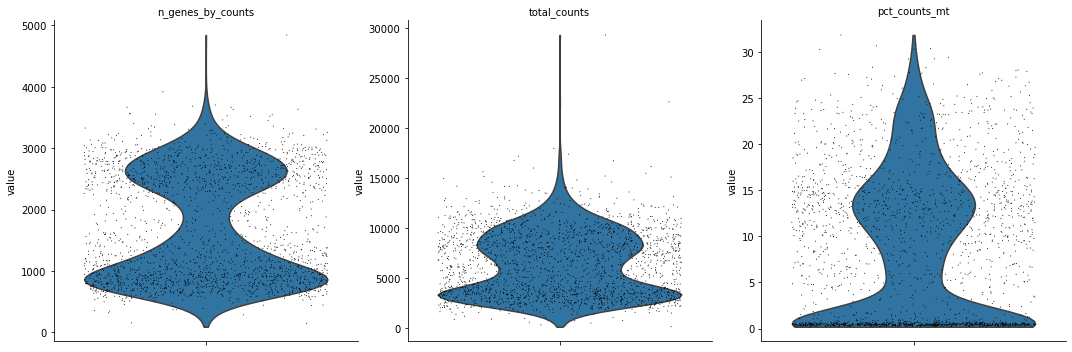

In [2]:
from util import *
import scanpy as sc

h5_path = 'E://human/GSM4838131_Visium_Sample_A_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838131_Visium_Sample_A_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838133_Visium_Sample_C_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838133_Visium_Sample_C_tissue_positions_list.csv'

h5_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

adata = sc.read_10x_h5(h5_path)
add_spatial_position(adata, csv_path)
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)

#sc.pp.filter_genes(adata, min_cells=2)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var_names_make_unique()

#adata = adata[adata.obs["pct_counts_mt"] < 8]

sc.pl.violin(adata, 
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


In [3]:
sc.pp.filter_genes(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 2179 × 13038
    obs: 'x', 'y', 'fig_x', 'fig_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells'
    obsm: 'spatial'

In [3]:
result = convolve(get_3D_matrix(adata), kernel=get_gaussian_kernel(size=5))
update_anndata(result, adata)

NameError: name 'get_3D_matrix' is not defined

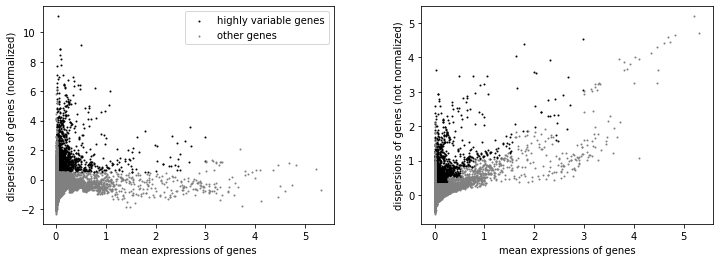

In [4]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [ ]:
# TODO: know why
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

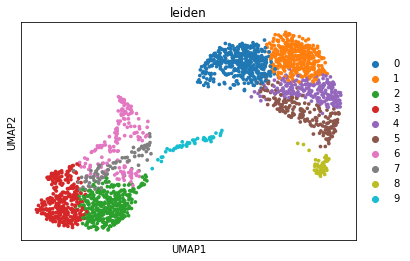

In [3]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

In [ ]:
sq.pl.spatial_scatter(adata, color='leiden', shape=None, dpi=200, size=24)

In [ ]:
tmp = adata[(adata.obs['leiden']=='3') |
            (adata.obs['leiden']=='0')]

In [ ]:

sc.tl.pca(tmp, svd_solver='arpack')
sc.pp.neighbors(tmp, n_neighbors=20, n_pcs=50)
sc.tl.umap(tmp)
sc.tl.leiden(tmp)
sc.pl.umap(tmp, color='leiden')

In [ ]:
sq.pl.spatial_scatter(tmp, color='leiden', shape=None, dpi=200, size=24)

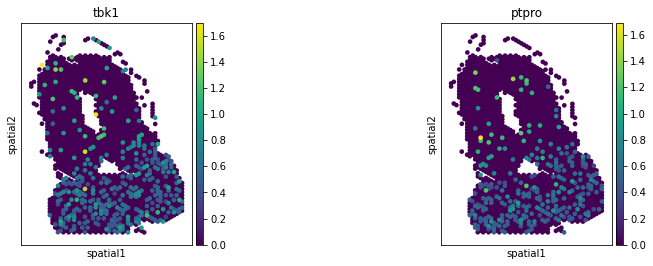

In [13]:
sc.pl.spatial(adata, 
              size=2,
              spot_size=300,
              color=['tbk1','ptpro'])

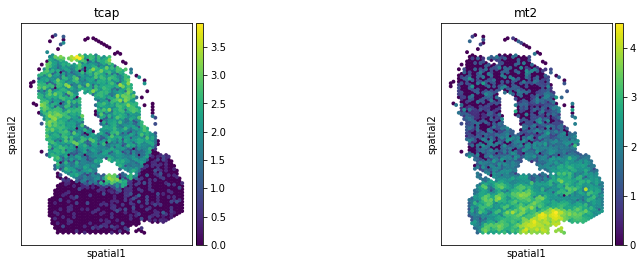

In [5]:
sc.pl.spatial(adata, 
              size=2,
              spot_size=250,
              color=['tcap', 'mt2'])

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from sklearn import mixture

sample = []
t = adata[:, adata.var_names == 'mt2']
for index, value in enumerate(t.X.todense()):
    tmp = int(value*10)
    if tmp > 0:
        for i in range(tmp):
            sample.append([int(t[index].obs.fig_x), int(t[index].obs.fig_y)])

gmm1 = mixture.GaussianMixture(n_components=10, max_iter=1000, warm_start=False)
gmm1.fit(sample)

GaussianMixture(max_iter=1000, n_components=10)

In [14]:
sample = []
t = adata[:, adata.var_names == 'ptpro']
for index, value in enumerate(t.X.todense()):
    tmp = int(value*10)
    if tmp > 0:
        for i in range(tmp):
            sample.append([int(t[index].obs.fig_x), int(t[index].obs.fig_y)])

gmm = mixture.GaussianMixture(n_components=5, max_iter=1000, warm_start=False)
gmm.fit(sample)

GaussianMixture(max_iter=1000, n_components=5)

In [15]:
bhat_distance(gmm, gmm1)

2.2320948727271044

In [8]:
import numpy as np
from scipy.stats import multivariate_normal

# 定义两个GMM
gmm1_weights = gmm.weights_
gmm1_means = gmm.means_
gmm1_covs = gmm.covariances_

gmm2_weights = gmm1.weights_
gmm2_means = gmm1.means_
gmm2_covs = gmm1.covariances_
n_components = gmm.weights_.size
# 计算所有组件之间的Bhattacharyya距离
bhat_dist = np.zeros((n_components, n_components))
for i in range(n_components):
    for j in range(n_components):
        mean_cov = 0.5*(gmm1_covs[i]+gmm2_covs[j])
        mean_cov_det = np.linalg.det(mean_cov)
        mean_cov_inv = np.linalg.inv(mean_cov)
        means_diff = gmm1_means[i] - gmm2_means[j]
        first_term = ((means_diff).T @ mean_cov_inv @ (means_diff))/8
        second_term = np.log(
            mean_cov_det/(np.sqrt(np.linalg.det(gmm1_covs[i]) * np.linalg.det(gmm1_covs[j]))))/2
        result = first_term+second_term
        bhat_dist[i, j] = result

min_bhat_dist = np.min(bhat_dist)
min_bd = bhat_dist * gmm1_weights.reshape(n_components, 1)
print("Bhattacharyya距离的最小值为:", np.sum(np.amin(min_bd, axis=1)))

Bhattacharyya距离的最小值为: 0.9334907579760766


In [10]:
from scipy.optimize import linear_sum_assignment

cost =bhat_dist
print(cost)
print('-'*10)
row_ind,col_ind=linear_sum_assignment(cost)
print(row_ind)
#开销矩阵对应的行索引
print(col_ind)
#对应行索引的最优指派的列索引
print(cost[row_ind,col_ind])
#提取每个行索引的最优指派列索引所在的元素，形成数组
print(cost[row_ind,col_ind].sum())

[[ 3.04931627 16.14377694  1.52665387  8.88890769  5.37604429]
 [ 0.29657906  1.45401841  2.10974886  3.11576314 -0.23953678]
 [ 2.47321914  9.09077931  2.62501299  9.07843476  1.91741286]
 [ 1.69279658  0.16027568  1.92334347 -0.26475772  1.90312948]
 [ 0.1676715   4.29602505 -0.26969105  1.11003864  2.53048684]]
----------
[0 1 2 3 4]
[2 1 4 3 0]
[ 1.52665387  1.45401841  1.91741286 -0.26475772  0.1676715 ]
4.800998924815606


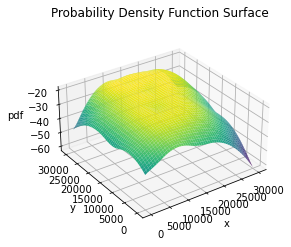

<Figure size 7200x7200 with 0 Axes>

In [19]:
# 网格化数据空间
x = np.linspace(0, 30000, 100)
y = np.linspace(0, 30000, 100)
X, Y = np.meshgrid(x, y)
XY = np.column_stack([X.flat, Y.flat])

# 计算概率密度函数值
Z = gmm1.score_samples(XY)
Z = Z.reshape(X.shape)

Z1 = gmm.score_samples(XY)
Z1 = Z1.reshape(X.shape)
# 绘制三维表面图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z1, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('pdf')
ax.set_box_aspect([2, 2, 1])
ax.set_title('Probability Density Function Surface')
#ax.grid(False)
#ax.axis('off')
ax.view_init(elev=30, azim=235)

plt.show()

In [ ]:
-np.log(np.sqrt(np.exp(Z1) * np.exp(Z)).sum())

In [ ]:
1-np.sqrt(np.exp(Z1) * np.exp(Z1)).sum()

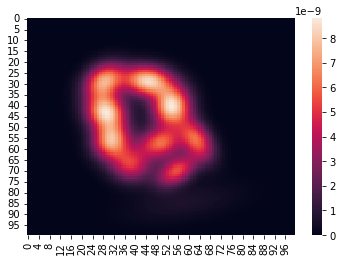

In [17]:
sns.heatmap(np.exp(Z))
plt.show()

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(total_list)
df['label'] = kmeans.labels_

In [ ]:
sns.scatterplot(data=df, x='x',y='y',hue='label')

In [ ]:
sc.tl.rank_genes_groups(tmp, groupby="leiden")
import matplotlib.pyplot as plt

sc.pl.rank_genes_groups_dotplot(tmp, 
                                groupby="leiden", 
                                figsize=(20,3)
                                )

In [ ]:
sc.pl.rank_genes_groups_heatmap(tmp, 
                                swap_axes=True,
                                groupby="leiden")

In [ ]:
sc.pl.rank_genes_groups_tracksplot(tmp, figsize=(25,15))